# Bernoulli Naive Bayes

This note introduces the **Bernoulli Naive Bayes** algorithm using `scikit‑learn`, explains the step‑by‑step logic behind how it works, and then demonstrates a from‑scratch implementation to show that the core idea is simple and easy to build.

## What is Bernoulli Naive Bayes?

Bernoulli Naive Bayes is like keeping a **yes / no checklist** for every e‑mail, for example:

- Does the message contain the word *money*?

This single‑word question is just an example — in practice the model asks the same *yes / no* question for **every word in the vocabulary**, and each word’s answer adds its own little score toward **spam** or **ham**. 

After summing all those scores, the class with the higher total wins.

It learns these scores from past data (how often each word shows up in spam versus ham). Adding them word‑by‑word is fast, requires no tuning knobs, and often beats fancier models on text tasks with binary features.

This notebook will:

- **Use `scikit‑learn`** to demonstrate how Bernoulli Naive Bayes works in practice  
- **Explain the logic behind it** in an intuitive way (scorecard view, Laplace smoothing, using logs instead of tiny products)  
- **Show how to implement the same idea step by step from scratch**  

Let’s dive into the details to understand how it works and how to implement it ourselves.

## Preparation


In [ ]:
# Bernoulli Naive Bayes on a REAL spam / ham dataset
# ==================================================
# “Spambase” (UCI ML Repo, OpenML ID = 44)

# --------------------------------------------------
# 0. Imports
# --------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)

# --------------------------------------------------
# 1. Load & binarise the dataset                 (↔ Section “Learn Word Probabilities”)
# --------------------------------------------------
spam = fetch_openml("spambase", version=1, as_frame=False)   # ~4 KB download
X_raw, y = spam.data, spam.target.astype(int)                # y ∈ {0 = ham, 1 = spam}

# Bernoulli NB expects 0/1 “word present?” flags.
X = Binarizer(threshold=0.0).fit_transform(X_raw)            # >0 → 1, else 0

# Keep a test split for honest evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Loaded {X.shape[0]} emails × {X.shape[1]} features")

Loaded 4601 emails × 57 features


## Data Observation

`X` holds 57 binary word‑flags (e.g. `word_freq_money = 1` if **money** appears); `y` is the spam / ham label for each e‑mail.  
By matching these flags to the labels, Bernoulli Naive Bayes learns a separate spam‑vs‑ham score for each word.

## Implement with Scikit-Learn

In [ ]:
# --------------------------------------------------
# 2. Reference model: scikit‑learn BernoulliNB
# --------------------------------------------------
sk_model = BernoulliNB(alpha=1.0)            # Laplace α = 1  (Section ‘Laplace Smoothing’)
sk_model.fit(X_train, y_train)

y_pred_sk  = sk_model.predict(X_test)
y_proba_sk = sk_model.predict_proba(X_test)[:, 1]            # P(spam)
acc_sk     = accuracy_score(y_test, y_pred_sk)
print(f"scikit‑learn accuracy = {acc_sk:.4f}")

scikit‑learn accuracy = 0.8818


## Behind the Scenes

Before we dive into the model, let’s understand the foundation it relies on: probability. This will give us the tools to calculate how likely an email is spam based on the words it contains.

### Probability Basics

Probability tells us how likely something is to happen. The result is always between 0 and 1.

In this section, we’ll learn 3 essential concepts:

1. Marginal Probability  
2. Joint Probability  
3. The Product Rule (with Conditional Probability)

We’ll use **coin flips** for all examples.

#### 1. Marginal Probability

This is the probability of a single event happening.

**Example — Flipping a coin:**

- The probability of getting Heads:

$$
P(\text{Heads}) = \frac{1}{2}
$$

- The probability of getting Tails:

$$
P(\text{Tails}) = \frac{1}{2}
$$

These are called **marginal probabilities** — they only involve one event.

#### 2. Joint Probability

This is the probability of **two events happening together**:

$$
P(A \cap B)
$$

**Example — Flipping two coins:**

- What’s the probability of getting Heads on the first **and** Heads on the second?

If the flips are **independent**:

$$
P(\text{Heads on both}) = \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{4}
$$

So for **independent events only**, the joint probability is:

$$
P(A \cap B) = P(A) \cdot P(B)
$$

If the events are **not independent**, we need the **product rule**.

#### 3. The Product Rule (with Conditional Probability)

The **product rule** handles both independent and dependent events:

$$
P(A \cap B) = P(A \mid B) \cdot P(B)
$$

This introduces **conditional probability**:

- $P(A \mid B)$ means "the probability of $A$, assuming $B$ has already happened."

**Example — Dependent coin flips:**

- $P(\text{First = Heads}) = \frac{1}{2}$
- If the first flip is Heads, we use a **special biased coin** for the second flip:  
  $P(\text{Second = Heads} \mid \text{First = Heads}) = 0.75$

Then:

$$
P(\text{Both Heads}) = \frac{1}{2} \cdot 0.75 = 0.375
$$

This shows how a conditional bias affects the joint probability.

#### From Product Rule to Bayes’ Theorem

We can also write the product rule the other way:

$$
P(B \cap A) = P(B \mid A) \cdot P(A)
$$

Since $P(A \cap B) = P(B \cap A)$, we can set them equal:

$$
P(A \mid B) \cdot P(B) = P(B \mid A) \cdot P(A)
$$

Now divide both sides by $P(B)$:

$$
P(A \mid B) = \frac{P(B \mid A) \cdot P(A)}{P(B)}
$$

This is **Bayes’ Theorem** — a way to reverse the direction of conditional probability.

Let’s see how we apply this to spam classification.

### Bayes' Theorem for Classification

Now let:
- $A = \text{Spam}$  
- $B = \text{Words in the email}$

$$
P(\text{Spam} \mid \text{Words}) = \frac{P(\text{Words} \mid \text{Spam}) \cdot P(\text{Spam})}{P(\text{Words})}
$$

Then: 

- We know how often certain words appear in spam:  
  → $P(\text{Words} \mid \text{Spam})$

- We know the overall proportion of spam:  
  → $P(\text{Spam})$

Bayes’ Theorem helps us compute $P(\text{Spam} \mid \text{Words})$ — the chance an email is spam **given** the words it contains.

We usually compare two classes:

$$
\frac{P(\text{Words} \mid \text{Spam}) \cdot P(\text{Spam})}{P(\text{Words})}
\quad \text{vs} \quad
\frac{P(\text{Words} \mid \text{Not Spam}) \cdot P(\text{Not Spam})}{P(\text{Words})}
$$

Since the denominator is the same, it cancels out:

$$
P(\text{Spam} \mid \text{Words}) \propto P(\text{Words} \mid \text{Spam}) \cdot P(\text{Spam})
$$

> The symbol $\propto$ means "proportional to" — we're only interested in which class has the higher score, so we can safely ignore the shared denominator.

Next, let’s simplify how we calculate the probability of the words.

### The Naive Assumption

Just like assuming each coin flip is independent makes probability easier to compute, we assume all words are **conditionally independent** given the class — so the overall probability can be calculated by simply multiplying each word’s probability:

$$
P(\text{Words} \mid \text{Spam}) = P(x_1 \mid \text{Spam}) \cdot P(x_2 \mid \text{Spam}) \cdot \cdots \cdot P(x_n \mid \text{Spam}) = \prod_{i=1}^{n} P(x_i \mid \text{Spam})
$$

> The symbol $\prod$ is the product symbol — like $\sum$ but for multiplication.

It's called *Naive* because this independence assumption is rarely true in real language — but it works surprisingly well in practice.

Now let’s look at how to actually estimate these word probabilities from data.

### Calculating Word Probabilities in Spam Emails

Now that we assume each word is independent, we need a way to calculate how likely each word appears in spam emails.

Here’s how it works:

#### 1. Learn Word Probabilities from Training Data

From the training data, we count how often each word appears in spam emails.

Let’s define:

- $x_i = 1$ means the $i$-th word is **present** in the email  
- $x_i = 0$ means the $i$-th word is **absent**

We want to estimate:

$$
\theta_i = P(x_i = 1 \mid \text{Spam}) = \frac{\text{Number of spam emails containing word } i}{\text{Total number of spam emails}}
$$

This gives us the probability that a spam email **contains** word $i$ at least once.

##### To Avoid Zero Probability: Laplace Smoothing

Sometimes a word might never appear in spam emails, which would give us a probability of 0 and cause the whole product to collapse.

To fix that, we use **Laplace smoothing**:

$$
\theta_i = \frac{\text{Number of spam emails containing word } i + \alpha}{\text{Total number of spam emails} + 2\alpha}
$$

Where:
- $\alpha$ is a small constant (usually 1)
- $2\alpha$ accounts for both word **present** and **absent** cases

#### 2. Check the Email for Each Word

For a new email, we check each word $x_i$:

- If the word **is present**: we use $\theta_i$  
- If the word **is absent**: we use $1 - \theta_i$

We can express both in a single formula:

$$
P(x_i \mid \text{Spam}) = \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i}
$$

Why it works:

- If $x_i = 1$:  
  $P(x_i \mid \text{Spam}) = \theta_i$

- If $x_i = 0$:  
  $P(x_i \mid \text{Spam}) = 1 - \theta_i$

#### 3. Multiply All Word Probabilities Together

Since we assumed all words are conditionally independent:

$$
P(\text{Words} \mid \text{Spam}) = \prod_{i=1}^{n} \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i}
$$

So we multiply each word’s probability — whether it’s present or not — to get the full likelihood for the email.

This is how Bernoulli Naive Bayes models text classification.

### Combine with Prior Probability

We also multiply by the prior probability of spam:

$$
P(\text{Spam}) = \frac{\text{Number of spam emails}}{\text{Total number of emails}}
$$

So the full expression becomes:

$$
P(\text{Spam} \mid \text{Words}) \propto P(\text{Spam}) \cdot \prod_{i=1}^{n} \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i}
$$

At this point, we have everything — but there’s still a problem when we try to compute this on a real machine.

### But There’s a Problem: Underflow

Multiplying many small probabilities can make the result **extremely tiny** — too small for the computer to represent accurately.

**Example:**

$$
0.9 \cdot 0.6 \cdot 0.1 \cdot 0.02 = 0.00108
$$

With hundreds of terms, the value might become so small it gets rounded to **0**. This is called **underflow**, and it breaks our calculation.

#### The Fix: Use Logarithms

Instead of multiplying probabilities, we take the **log** and add them — this avoids underflow and is easier to compute.

#### Log Rules We’ll Use

We’ll use these two key log rules:

- $\log(a \cdot b) = \log a + \log b$  
- $\log(a^b) = b \cdot \log a$  

#### Why It Works: A Simple Example

Let’s take the log of the earlier multiplication:

$$
\log(0.9 \cdot 0.6 \cdot 0.1 \cdot 0.02) = \log(0.9) + \log(0.6) + \log(0.1) + \log(0.02)
$$

Approximate values:

$$
= -0.105 + (-0.222) + (-1.0) + (-1.699) = -3.026
$$

Instead of a tiny number like **0.00108**, we now get a manageable value: **–3.026**

#### Apply to Bernoulli Naive Bayes

We start from:

$$
P(\text{Spam} \mid \text{Words}) \propto P(\text{Spam}) \cdot \prod_{i=1}^{n} \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i}
$$

Take the log:

$$
\log P(\text{Spam} \mid \text{Words}) \propto \log P(\text{Spam}) + \log \prod_{i=1}^{n} \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i}
$$

Convert the product into a sum:

$$
\log P(\text{Spam} \mid \text{Words}) \propto \log P(\text{Spam}) + \sum_{i=1}^{n} \log\left( \theta_i^{x_i} \cdot (1 - \theta_i)^{1 - x_i} \right)
$$

Break inside the log:

$$
\log P(\text{Spam} \mid \text{Words}) \propto \log P(\text{Spam}) + \sum_{i=1}^{n} \left[ \log(\theta_i^{x_i}) + \log((1 - \theta_i)^{1 - x_i}) \right]
$$

Apply the power rule:

$$
\log P(\text{Spam} \mid \text{Words}) \propto \log P(\text{Spam}) + \sum_{i=1}^{n} \left[ x_i \log \theta_i + (1 - x_i) \log(1 - \theta_i) \right]
$$

## Let's Code It

Now that we’ve covered all the logic behind Bernoulli Naive Bayes — from probability theory to handling underflow with logs — it’s time to **implement it from scratch**!

In [ ]:
# --------------------------------------------------
# 3. From‑scratch Bernoulli Naive Bayes (now with “what is happening” comments)
# --------------------------------------------------
class MyBernoulliNB:
    def __init__(self, alpha: float = 1.0):
        # α = 1  →  classic Laplace smoothing (“add‑one”)
        # avoids zero probabilities when a word never appears in one class
        self.alpha = alpha

    # ==================== TRAIN ====================
    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        X  ─ shape (n_emails, n_words)
             1 = word appears at least once, 0 = absent
        y  ─ shape (n_emails,)
             0 = ham, 1 = spam
        """
        n_emails, n_words = X.shape
        self.classes_ = np.array([0, 1])        # fixed order: [ham, spam]

        # ---------- 1. PRIOR P(class) ----------
        # How many emails are ham / spam?
        class_counts        = np.bincount(y, minlength=2)      # shape (2,)
        self.log_prior_     = np.log(class_counts / n_emails)  # log for later addition

        # ---------- 2. WORD PROBABILITIES θ ----------
        # word_present[c, j] = how many emails of class c contain word j
        word_present = np.array([
            X[y == 0].sum(axis=0),   # ham row  (shape (n_words,))
            X[y == 1].sum(axis=0)    # spam row
        ])                            # overall shape (2, n_words)

        # emails_per_class[0] = #ham emails, [1] = #spam emails
        emails_per_class = class_counts.reshape(-1, 1)          # shape (2, 1)

        # θ = smoothed fraction of emails *with* the word (per class & word)
        theta = (word_present + self.alpha) / (emails_per_class + 2 * self.alpha)
        #         ↑ numerator            ↑ denominator (present + absent)

        # Store both log θ   and   log (1‑θ)
        self.log_theta_present_ = np.log(theta)      # when word flag = 1
        self.log_theta_absent_  = np.log(1 - theta)  # when word flag = 0
        return self

    # =================== PREDICT ===================
    def predict(self, X: np.ndarray):
        """
        Score matrix logic (vectorised):

        scores[:, 0]  = ham_log_prior
                      + sum_i [word_i_present * log θ_ham,i
                               + word_i_absent  * log (1‑θ_ham,i)]

        same for column 1 (spam).  The bigger column wins.
        """

        #  X              shape: (n_test, n_words)
        #  log_theta_.T   shape: (n_words, 2)
        #  X @ ...        →     (n_test, 2)    (sum of present‑word logs)
        scores = (
            self.log_prior_                               # broadcast to (n_test, 2)
            + X       @ self.log_theta_present_.T         # add logs for present words
            + (1 - X) @ self.log_theta_absent_.T          # add logs for absent words
        )
        # For each email (row) pick class index with higher score
        return self.classes_[scores.argmax(axis=1)]

my_nb      = MyBernoulliNB(alpha=1.0).fit(X_train, y_train)
y_pred_my  = my_nb.predict(X_test)
acc_my     = accuracy_score(y_test, y_pred_my)
print(f"scratch accuracy = {acc_my:.4f}")

scratch accuracy = 0.8818


The scratch model hits an accuracy of **0.8818**, matching scikit‑learn.  

Next, let’s plot a **confusion matrix** to see which e‑mails were classified correctly and where mistakes happen.

## Comparison

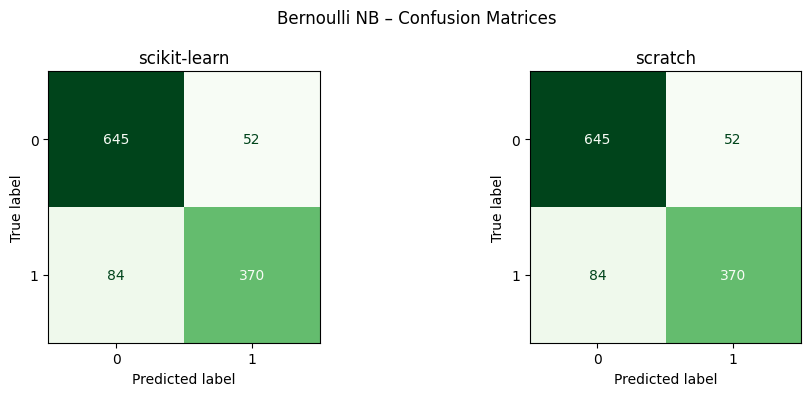

In [ ]:
# --------------------------------------------------
# 4. Visual diagnostics (no 2‑D decision boundary)
# --------------------------------------------------

# --- Confusion matrices ------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, preds, title in zip(
    axes, [y_pred_sk, y_pred_my], ["scikit‑learn", "scratch"]
):
    ConfusionMatrixDisplay.from_predictions(
        y_test, preds, cmap="Greens", ax=ax, colorbar=False
    )
    ax.set_title(title)
fig.suptitle("Bernoulli NB – Confusion Matrices")
plt.tight_layout()
plt.show()

## It Works!!

The predictions from our scratch **Bernoulli Naive Bayes** implementation line up perfectly with the results from **scikit‑learn**.

This confirms that our logic — counting word occurrences, adding Laplace smoothing, summing log‑likelihoods, and picking the class with the higher total — behaves exactly as expected.

We've successfully built **Bernoulli Naive Bayes** from the ground up!